In [21]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=128"


In [22]:
import SSjax
import NSjax
import NNjax
import h5py
import json
import time
import numpy
import pyccl
import scipy
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.lines as mlines
import multiprocessing
import psutil
import threading

In [23]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NS'

'''
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='SS'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)
'''

"\nsynthesize_folder = os.path.join(folder, 'SYNTHESIZE/')\n\ntag='Y1'\ntyp='FIDUCIAL'\nlabel='DOUBLE'\nname='SS'\n\nos.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)\nos.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)\n"

In [24]:
# Load data
with h5py.File('/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/CALIBRATE/{}/CORRECT/TITANIUM/HYBRID.hdf5'.format(tag), 'r') as file:
    data_source = file['source']['data'][...]
data_size, bin_source_size, z_size = data_source.shape

# Alignment
with open(os.path.join(info_folder, 'ALIGNMENT.json'), 'r') as file:
    alignment_info = json.load(file)

In [25]:
# Redshift
z1 = 0.0
z2 = 3.0
z_grid = numpy.linspace(z1, z2, z_size)

In [26]:
# Cosmology
with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    cosmology_info = json.load(file)

Omega_m = cosmology_info['OMEGA_M']

cosmology = pyccl.Cosmology(
    h=cosmology_info['H'],
    w0=cosmology_info['W0'],
    wa=cosmology_info['WA'],
    n_s=cosmology_info['NS'], 
    A_s=cosmology_info['AS'], 
    m_nu=cosmology_info['M_NU'],
    Neff=cosmology_info['N_EFF'],
    Omega_k=cosmology_info['OMEGA_K'], 
    Omega_b=cosmology_info['OMEGA_B'], 
    Omega_c=cosmology_info['OMEGA_CDM'],
    Omega_g=cosmology_info['OMEGA_GAMMA'], 
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

    
pyccl.spline_params.N_K = z_size
pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = True

In [27]:
# Multipole
ell1 = 20
ell2 = 2000
ell_size = 20
ell_grid = numpy.geomspace(ell1, ell2, ell_size + 1)
ell_data = numpy.sqrt(ell_grid[+1:] * ell_grid[:-1])

SOURCE_PSI_GRID = numpy.mean(data_source, axis = 0)
SOURCE_SIGMA_GRID = numpy.std(data_source, axis = 0)
A_GRID = numpy.array(1 / (1 + z_grid), dtype = 'double')

CHI_GRID = cosmology.comoving_radial_distance(a = A_GRID)
SOURCE_PHI_GRID = SOURCE_PSI_GRID * cosmology.h_over_h0(a = 1 / (1 + z_grid)) * cosmology_info['H'] * 100000 / scipy.constants.c

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ell_grid)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ell_size + 1, z_size)) + numpy.inf, where = CHI_MESH > 0))
POWER_GRID = numpy.zeros((ell_size + 1, z_size))
for GRID_INDEX in range(z_size):

    POWER_GRID[:,GRID_INDEX] = cosmology.nonlin_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])

AMPLITUDE = 9 / 4 * Omega_m**2 * (cosmology_info['H'] * 100000 / scipy.constants.c)**4 * (1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1))
AMPLITUDE_IS = 3 / 2 * Omega_m * (cosmology_info['H'] * 100000 / scipy.constants.c)**2 * numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
AMPLITUDE_II = 1

In [28]:
# Define angular power spectrum

def q_m_chi_SS(chi_data, chi_grid, phi_m_grid, type):

    phi_m = scipy.interpolate.interp1d(chi_grid, phi_m_grid, kind = type)
    
    data_size = chi_data.shape[0] - 1
    q = numpy.zeros(data_size + 1)

    for n in range(data_size + 1):
        
        function = lambda chi_prime: phi_m(chi_prime) * (chi_prime - chi_data[n]) / chi_prime
        q[n] = scipy.integrate.fixed_quad(func = function, a = chi_data[n], b = chi_grid.max(), n = 500)[0]

    return q

def c_m1_m2_SS(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    a = scipy.interpolate.interp1d(chi_grid, 1 / (1 + redshift_grid), kind = type)

    pmm = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
   
    function = lambda chi: q_m_chi_SS(chi, chi_grid, phi_m1_grid, type) * q_m_chi_SS(chi, chi_grid, phi_m2_grid, type) * pmm(chi) / a(chi)**2
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

def q_m_chi_NS(chi_data, chi_grid, phi_m_grid, type):

    phi_m = scipy.interpolate.interp1d(chi_grid, phi_m_grid, kind = type)
    
    data_size = chi_data.shape[0] - 1
    q = numpy.zeros(data_size + 1)

    for n in range(data_size + 1):
        
        function = lambda chi_prime: phi_m(chi_prime) * (chi_prime - chi_data[n]) / chi_prime
        q[n] = scipy.integrate.fixed_quad(func = function, a = chi_data[n], b = chi_grid.max(), n = 500)[0]

    return q

def c_m1_m2_NS(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    a = scipy.interpolate.interp1d(chi_grid, 1 / (1 + redshift_grid), kind = type)

    pgm = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * q_m_chi_NS(chi, chi_grid, phi_m2_grid, type) * pgm(chi) / (chi * a(chi))
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

def c_m1_m2_NN(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    pgg = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid, kind = type)
    
    phi_m2 = scipy.interpolate.interp1d(chi_grid, phi_m2_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * phi_m2(chi) * pgg(chi) / (chi**2)
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

In [29]:
#Angular power Spectra(CCL)

C_CCL = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA1_SS = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA1_IS = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA1_II = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA2_SS = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA2_IS = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA2_II = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA3_SS = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA3_IS = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
C_DATA3_II = numpy.zeros((bin_source_size, bin_source_size, ell_size+1))
    
l_correct=numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
A = numpy.asarray(alignment_info['A'])
POWER_GRID_IS = POWER_GRID * A
POWER_GRID_II = POWER_GRID * A * A
T_pyccl=0
for (i, j) in product(range(bin_source_size), range(bin_source_size)):
    T0 = time.time()
    tracer1 = pyccl.tracers.WeakLensingTracer(cosmo=cosmology, dndz=[z_grid, SOURCE_PSI_GRID[i, :]], has_shear=True, ia_bias=[z_grid, alignment_info['A']], use_A_ia=False, n_samples=z_size)
    tracer2 = pyccl.tracers.WeakLensingTracer(cosmo=cosmology, dndz=[z_grid, SOURCE_PSI_GRID[j, :]], has_shear=True, ia_bias=[z_grid, alignment_info['A']], use_A_ia=False, n_samples=z_size)
    C_CCL[i, j,:] = pyccl.cells.angular_cl(cosmo=cosmology, tracer1=tracer1, tracer2=tracer2, ell=ell_grid, p_of_k_a='delta_matter:delta_matter', l_limber=-1, limber_max_error=0.01, limber_integration_method='qag_quad', non_limber_integration_method='FKEM', fkem_chi_min=0, fkem_Nchi=z_size, p_of_k_a_lin='delta_matter:delta_matter', return_meta=False)
    T1 = time.time()
    T_pyccl=T_pyccl+T1-T0
        
    for ELL_INDEX in range(ell_size + 1):
        
        C_DATA1_SS[i, j, ELL_INDEX] = c_m1_m2_SS(amplitude = AMPLITUDE[ELL_INDEX], phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA1_IS[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*c_m1_m2_NS(amplitude =AMPLITUDE_IS[ELL_INDEX], phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_IS[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA1_II[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*l_correct[ELL_INDEX]*c_m1_m2_NN(amplitude =AMPLITUDE_II, phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_II[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA2_SS[i, j, ELL_INDEX] = c_m1_m2_SS(amplitude = AMPLITUDE[ELL_INDEX], phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA2_IS[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*c_m1_m2_NS(amplitude =AMPLITUDE_IS[ELL_INDEX], phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_IS[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA2_II[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*l_correct[ELL_INDEX]*c_m1_m2_NN(amplitude =AMPLITUDE_II, phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_II[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA3_SS[i, j, ELL_INDEX] = c_m1_m2_SS(amplitude = AMPLITUDE[ELL_INDEX], phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')
        C_DATA3_IS[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*c_m1_m2_NS(amplitude =AMPLITUDE_IS[ELL_INDEX], phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_IS[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')
        C_DATA3_II[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*l_correct[ELL_INDEX]*c_m1_m2_NN(amplitude =AMPLITUDE_II, phi_m1_grid = SOURCE_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_II[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')
        
    T2 = time.time()
    print(i, j, T1 - T0, T2 - T1)
C_DATA1=C_DATA1_SS+C_DATA1_IS+numpy.transpose(C_DATA1_IS, (1, 0, 2))+C_DATA1_II
C_DATA2=C_DATA2_SS+C_DATA2_IS+numpy.transpose(C_DATA2_IS, (1, 0, 2))+C_DATA2_II
C_DATA3=C_DATA3_SS+C_DATA3_IS+numpy.transpose(C_DATA3_IS, (1, 0, 2))+C_DATA3_II
print('pyccl calculation time for SS:%fs' %T_pyccl)

0 0 0.05286145210266113 4.966557741165161
0 1 0.05574798583984375 5.315751791000366
0 2 0.05948591232299805 5.264768838882446
0 3 0.04851579666137695 5.337597608566284
0 4 0.042169809341430664 5.647512912750244
1 0 0.05583071708679199 5.012670993804932
1 1 0.053636789321899414 5.0096657276153564
1 2 0.053225040435791016 4.776652097702026
1 3 0.05282425880432129 4.80667519569397
1 4 0.05333566665649414 4.794801473617554
2 0 0.0533900260925293 4.809529542922974
2 1 0.05285382270812988 4.877006769180298
2 2 0.05347180366516113 4.866170406341553
2 3 0.052671194076538086 4.817997455596924
2 4 0.05359244346618652 4.8637566566467285
3 0 0.05345344543457031 4.913492441177368
3 1 0.05315041542053223 4.889526844024658
3 2 0.05367708206176758 4.878571271896362
3 3 0.05425119400024414 4.880089998245239
3 4 0.05337357521057129 4.799927473068237
4 0 0.05393815040588379 4.844502210617065
4 1 0.0539240837097168 5.231078624725342
4 2 0.054442644119262695 4.924225568771362
4 3 0.0531313419342041 4.84242

In [30]:
#Angular power Spectra(TensorCloud)
def test_ss_jax(AMPLITUDE, AMPLITUDE_II, AMPLITUDE_IS, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRIDSS, Alignment, REDSHIFT_GRID):
    # Get the total number of CPU cores
    total_cpu_count = multiprocessing.cpu_count()
    print(f"Total available CPU cores: {total_cpu_count}")

    # Usage of CPU 
    samples = []
    stop_evt = threading.Event()
    def sampler():
        while not stop_evt.is_set():
            samples.append(psutil.cpu_percent(interval=None, percpu=True))
            time.sleep(0.1)

    t = threading.Thread(target=sampler)
    t.start()

    start_time = time.time()
    
    l_correct=numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
    A = numpy.asarray(Alignment)

    # Run the SSs function
    result_SS=numpy.asarray(SSjax.function(AMPLITUDE, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID, REDSHIFT_GRID))
    result_II=numpy.asarray(l_correct*l_correct*NNjax.function(AMPLITUDE_II, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID * A * A, REDSHIFT_GRID))
    result_IS=numpy.asarray(l_correct*NSjax.function(AMPLITUDE_IS, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID * A, REDSHIFT_GRID))
    result_SI = numpy.transpose(result_IS, (1, 0, 2))
    
    

    end_time = time.time()
    print(f"SSjax execution time: {end_time - start_time} seconds")

    
    stop_evt.set()
    t.join()
    arr = numpy.array(samples)  # shape: (n_samples, n_cores)
    mean_per_core = arr.mean(axis=0)
    active_cores = (mean_per_core > 5).sum()
    print(f"Average number of active cores：{active_cores}/{total_cpu_count}")
    print(f"Average utilization per core：{numpy.round(mean_per_core, 1)}")
    return result_SS+result_IS+result_SI+result_II

C_DATA = numpy.array(test_ss_jax(AMPLITUDE,AMPLITUDE_II,AMPLITUDE_IS, SOURCE_PHI_GRID, SOURCE_PHI_GRID, CHI_GRID, POWER_GRID,alignment_info['A'], z_grid))

Total available CPU cores: 128
SSjax execution time: 16.14281439781189 seconds
Average number of active cores：128/128
Average utilization per core：[14.7 14.1 14.2 14.7 14.1 14.2 14.9 14.4 14.7 14.5 15.  13.9 14.  15.1
 14.5 14.6 14.7 15.3 14.5 14.8 14.8 15.6 15.  14.5 15.1 14.5 14.7 18.8
 15.2 15.2 15.  16.3 14.6 14.2 14.4 15.1 15.1 15.1 14.8 14.3 14.4 16.2
 14.1 14.5 14.2 15.  14.4 14.6 15.  14.4 14.  14.7 14.9 15.2 16.  14.8
 15.9 14.6 14.7 15.  14.3 15.2 14.9 14.7 13.5 14.  14.4 14.3 14.8 14.2
 14.7 14.1 15.  14.2 14.8 14.1 14.5 15.3 14.2 14.4 15.7 15.2 15.1 14.9
 15.  15.9 14.7 14.6 14.6 19.1 15.7 31.4 14.7 14.9 14.8 14.7 14.6 15.
 14.2 15.2 14.5 14.9 14.3 14.7 14.5 16.3 14.7 14.7 15.1 15.9 14.1 14.1
 15.2 14.3 14.8 14.6 14.8 15.3 14.7 15.4 16.6 14.7 15.1 14.8 14.4 15.3
 15.2 14.4]


In [31]:
#Calculate the difference
C_RATIO = numpy.divide(C_DATA, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO1 = numpy.divide(C_DATA1, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO2 = numpy.divide(C_DATA2, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO3 = numpy.divide(C_DATA3, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)

In [32]:
# Bin
with h5py.File(os.path.join(model_folder, '{}/TARGET/DATA0.hdf5'.format(tag)), 'r') as file:
    bin_lens = file['bin_lens'][...]
    bin_source = file['bin_source'][...]

bin_lens_size = len(bin_lens) - 1
bin_source_size = len(bin_source) - 1

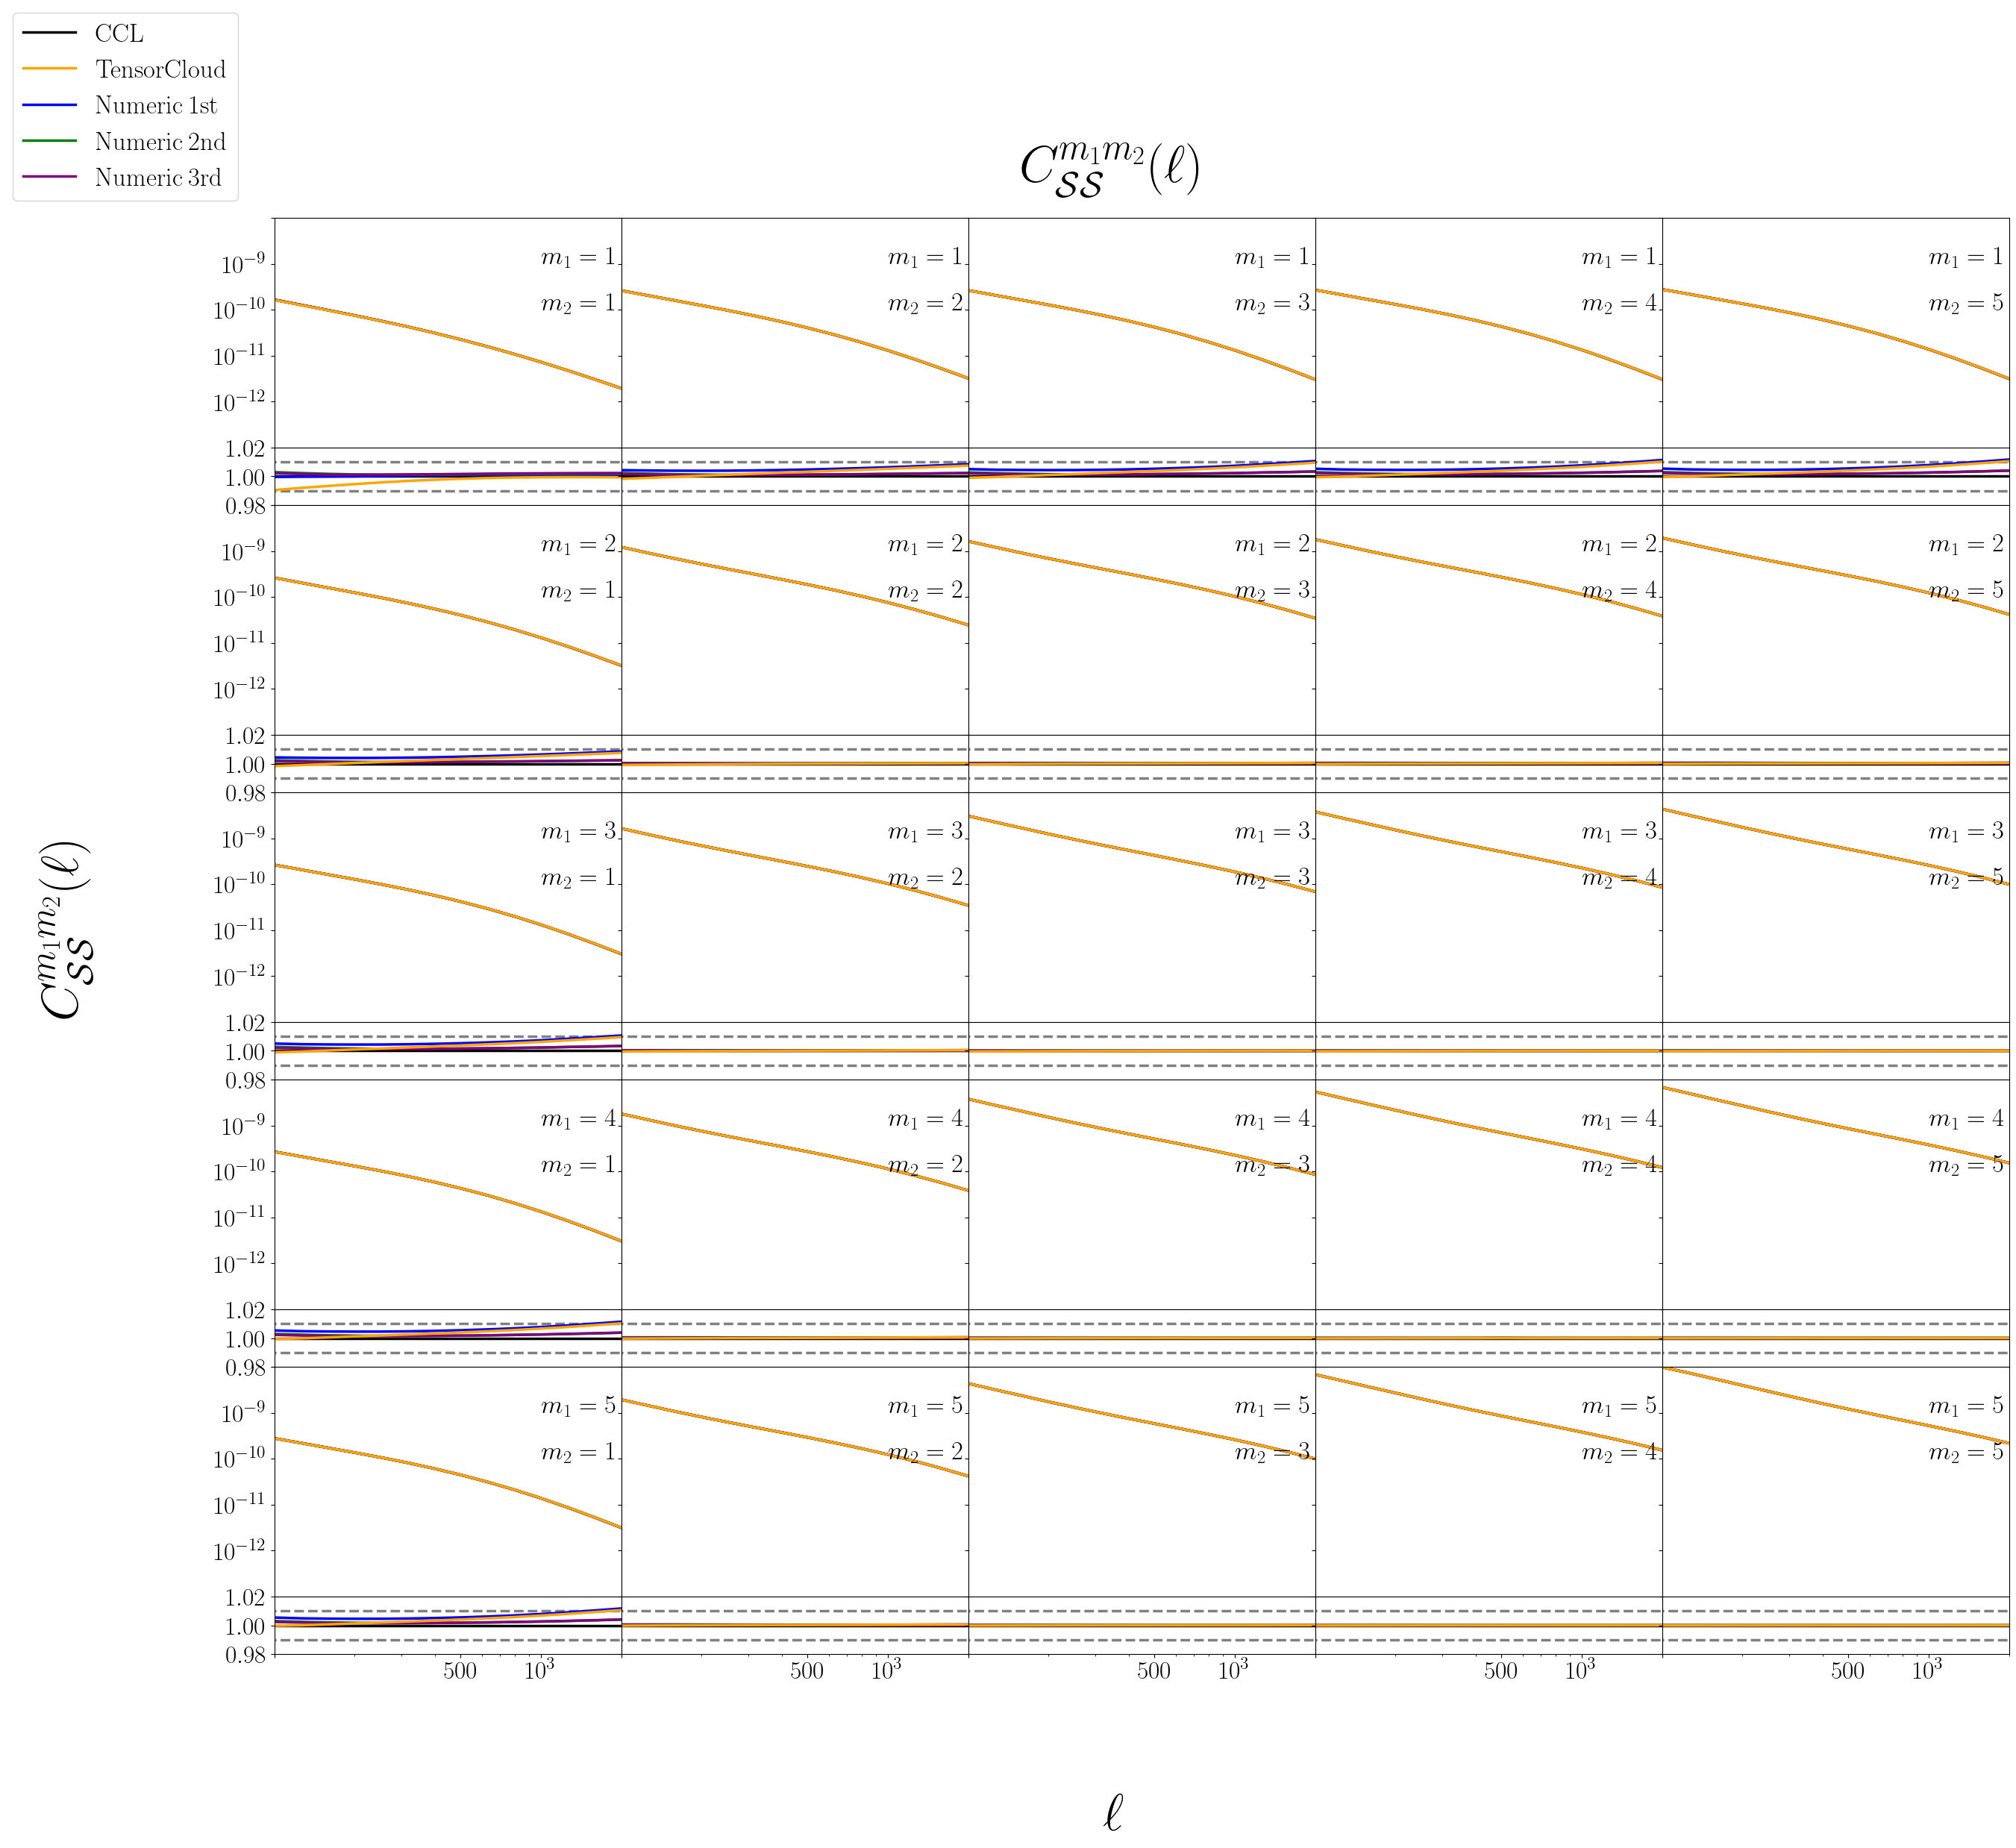

In [33]:
#Compare different bins
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_source_size * 6, bin_source_size * 5))
GRIDSPEC = GridSpec(5 * bin_source_size, 6 * bin_source_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_source_size), range(bin_source_size)):
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[5 * BIN_INDEX1: 5 * BIN_INDEX1 + 4, 6 * BIN_INDEX2: 6 * BIN_INDEX2 + 6])

    PLOT.plot(ell_grid, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

    PLOT.plot(ell_grid, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

    PLOT.plot(ell_grid, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')
    
    PLOT.plot(ell_grid, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')
    
    PLOT.plot(ell_grid, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

    PLOT.text(x = 10**3, y = 10**-9, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

    PLOT.text(x = 10**3, y = 10**-10, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)

    PLOT.set_ylim(10**-13, 10**-8)
    PLOT.yaxis.set_major_locator(FixedLocator([10**-8,10**-9,10**-10, 10**-11, 10**-12]))
    PLOT.yaxis.set_major_formatter(FixedFormatter([r'${10}^{-8}$',r'${10}^{-9}$', r'${10}^{-10}$', r'${10}^{-11}$', r'${10}^{-12}$']))
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5 + 4: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(ell_grid, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(ell_grid, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.98, 1.02)
    PLOT.xaxis.set_major_locator(FixedLocator([100, 500, 1000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'$100$', r'$500$', r'${10}^3$']))

    if BIN_INDEX1 < bin_source_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize = 50)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.show()

In [34]:
#Rebinning
def compute_cell_block(cell_grid, ell_grid):
    N_bin1 = cell_grid.shape[0]
    N_bin2 = cell_grid.shape[1]
    N_ell = cell_grid.shape[2]
    
    log_ell = numpy.log(ell_grid)
    normalized_grid = numpy.zeros((N_bin1, N_bin2, N_ell - 1))  
    new_ell_grid = 0.5 * (ell_grid[:-1] + ell_grid[1:])

    for i in range(N_bin1):
        for j in range(N_bin2):
            y = ell_grid * cell_grid[i, j, :]
            spline = scipy.interpolate.CubicSpline(x=log_ell, y=y, bc_type='natural', extrapolate=True)

            for k in range(N_ell - 1):
                log_lmin = numpy.log(ell_grid[k])
                log_lmax = numpy.log(ell_grid[k + 1])
                delta_ell = ell_grid[k + 1] - ell_grid[k]

                val = spline.integrate(log_lmin, log_lmax) / delta_ell
                normalized_grid[i, j, k] = val

    return normalized_grid,new_ell_grid




C_CCL_rebinned, ell_grid_rebinned=compute_cell_block(C_CCL, ell_grid)
C_DATA_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA, ell_grid)
C_DATA1_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA1, ell_grid)
C_DATA2_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA2, ell_grid)
C_DATA3_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA3, ell_grid)
C_RATIO_rebinned = numpy.divide(C_DATA_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO1_rebinned = numpy.divide(C_DATA1_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO2_rebinned = numpy.divide(C_DATA2_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO3_rebinned = numpy.divide(C_DATA3_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)

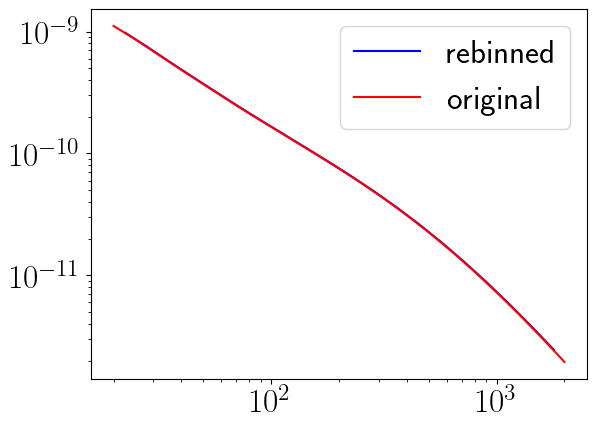

In [35]:
import matplotlib.pyplot as plt
plt.plot(ell_grid_rebinned,C_CCL_rebinned[0][0], color = 'blue',label='rebinned')
plt.plot(ell_grid,C_CCL[0][0], color = 'red',label='original')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [36]:
#diagonal covariance

k_maximal_source = 1.0 * cosmology_info['H']
ell_maximal_source = k_maximal_source * pyccl.comoving_radial_distance(cosmo=cosmology, a=1 / (1 + bin_source)) - 1 / 2

# Covariance
cell_range1 = bin_lens_size * (bin_lens_size + 1) // 2 * ell_size + bin_lens_size * bin_source_size * ell_size
cell_range2 = cell_range1 + bin_source_size * (bin_source_size + 1) // 2 * ell_size

covariance = numpy.loadtxt(os.path.join(cell_folder, '{}/COVARIANCE/TITANIUM/MATRIX.ascii'.format(tag, label)), dtype=numpy.float32)
variance = numpy.diagonal(covariance, axis1=0, axis2=1)
sigma = numpy.sqrt(variance)[cell_range1: cell_range2]


sigma_matrix = numpy.zeros((bin_source_size, bin_source_size, ell_size))
idx = 0
for m in range(bin_source_size):
    for n in range(m, bin_source_size):
        seg = sigma[idx*ell_size:(idx+1)*ell_size]    
        sigma_matrix[m, n, :] = seg
        sigma_matrix[n, m, :] = seg
        idx += 1
cell_DATA_zeta = numpy.divide(numpy.abs(C_DATA_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA1_zeta = numpy.divide(numpy.abs(C_DATA1_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA2_zeta = numpy.divide(numpy.abs(C_DATA2_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA3_zeta = numpy.divide(numpy.abs(C_DATA3_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)

In [37]:
#redshift variance
'''
with h5py.File(os.path.join(cell_folder, '{}/{}/{}_DATA_{}.hdf5'.format(tag, name, typ, label)), 'r') as file:
        cell_data = file['data'][...]
cell_data_error = numpy.std(cell_data, axis = 0)
#sigma_all = sigma_matrix + cell_data_error 
sigma_all = numpy.sqrt(sigma_matrix**2 + cell_data_error**2)# /sqrt(a^2+b^2)
'''
sigma_all = sigma_matrix

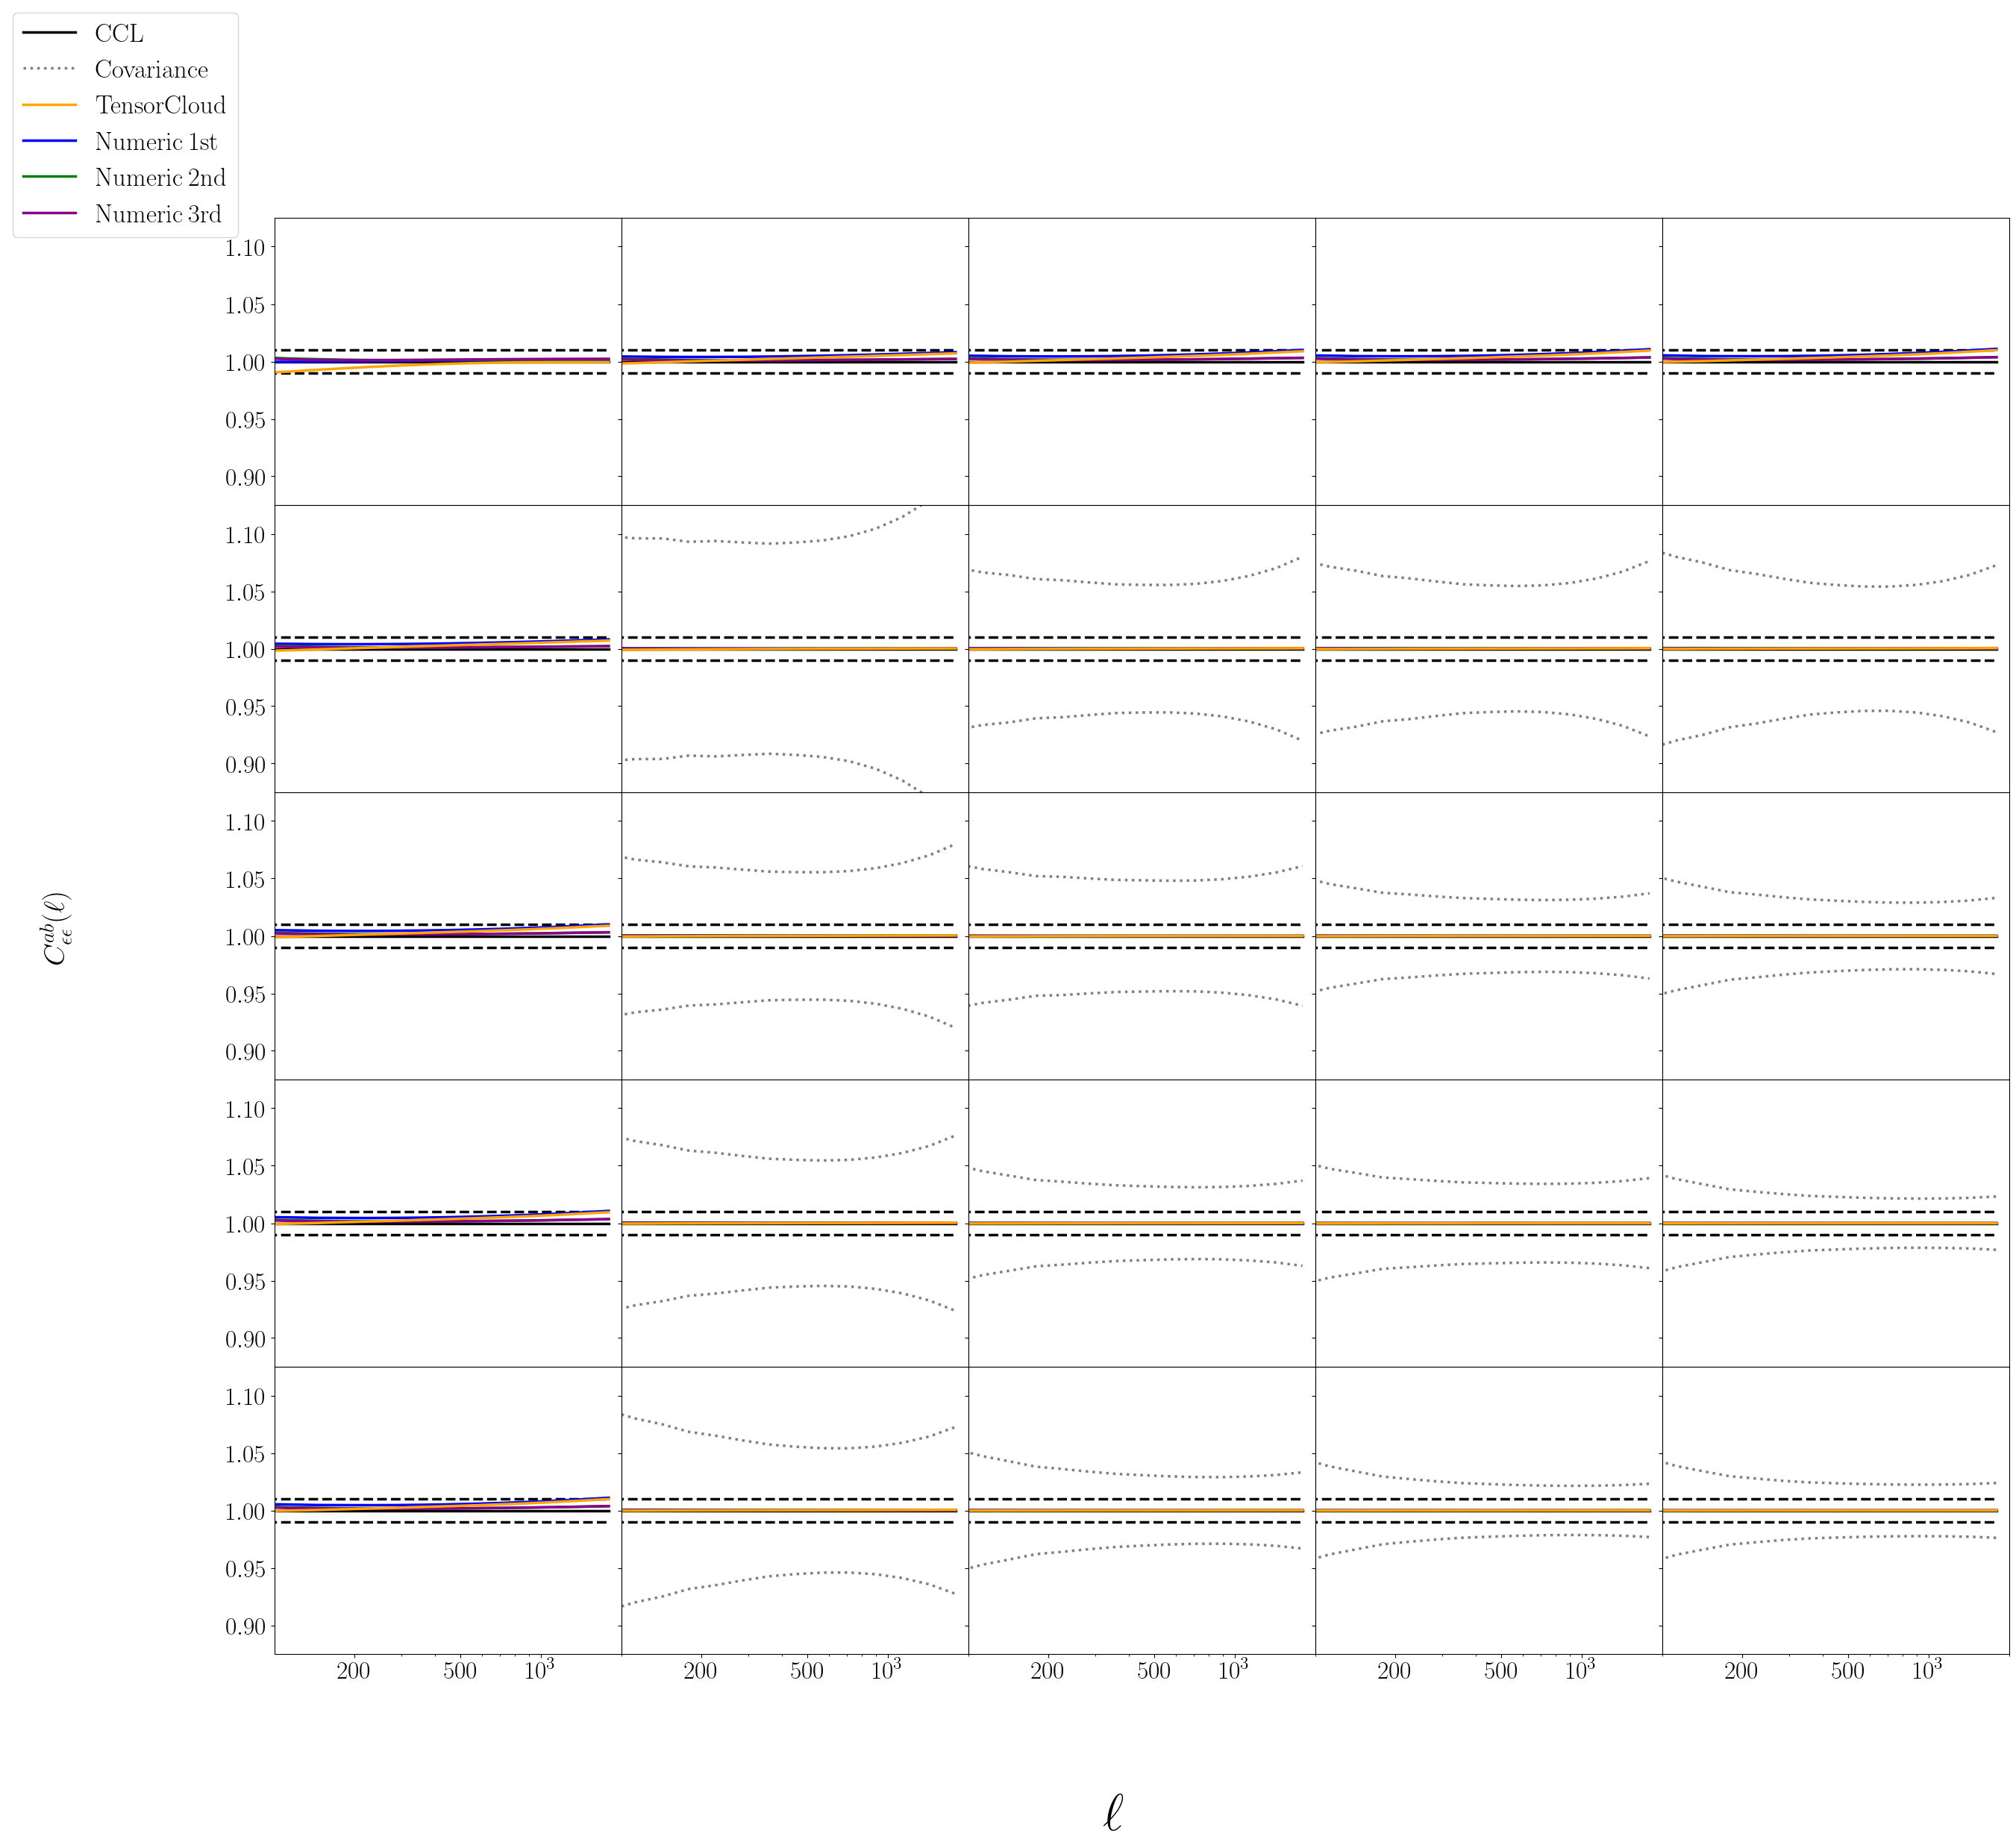

In [38]:
#Compare different bins(After rebinning)
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_source_size * 6, bin_source_size * 5))
GRIDSPEC = GridSpec(5 * bin_source_size, 6 * bin_source_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_source_size), range(bin_source_size)):

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size), color = 'black', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 + 0.01), color = 'black', linestyle = '--', linewidth = 2.5)
    
    PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 - 0.01), color = 'black', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)+ sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)
    
    PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)- sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)

    PLOT.plot(ell_grid_rebinned, C_RATIO1_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid_rebinned, C_RATIO2_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(ell_grid_rebinned, C_RATIO3_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'darkmagenta', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(ell_grid_rebinned, C_RATIO_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.875, 1.125)
    PLOT.xaxis.set_major_locator(FixedLocator([200, 500, 1000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'$200$', r'$500$', r'${10}^3$']))

    if BIN_INDEX1 < bin_source_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='grey', linestyle=':', linewidth=2.5, label=r'$\mathrm{Covariance}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='darkmagenta', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
#FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
#FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize = 50)
FIGURE.supylabel(r'$C_{\epsilon \epsilon}^{ab} (\ell)$')

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('Cepseps-Y1-cov.png')
FIGURE.show()

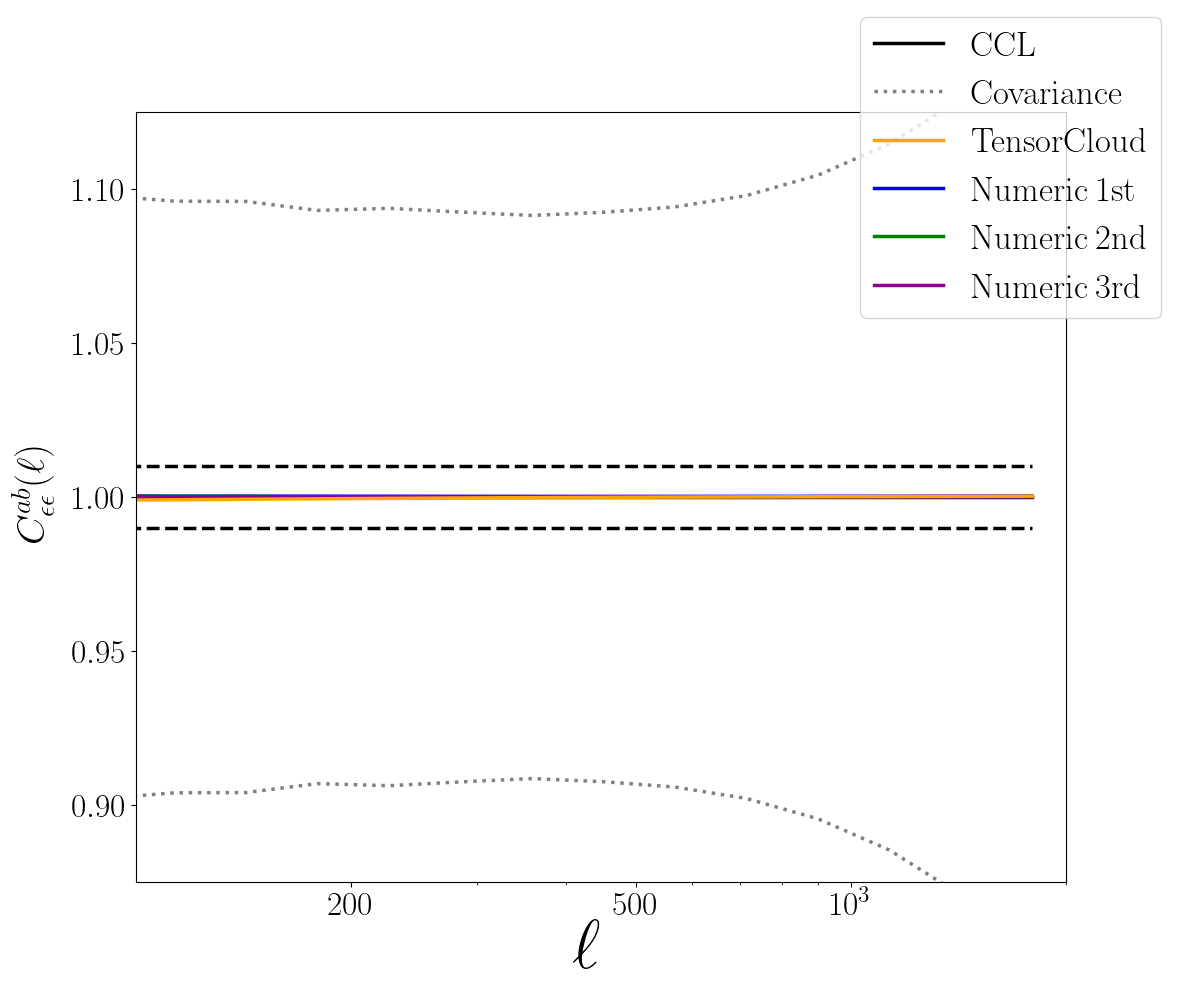

In [39]:
#Compare different bins(After rebinning)
BIN_INDEX1=1
BIN_INDEX2=1
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)


PLOT = FIGURE.add_subplot(GRIDSPEC[:, :]) 

PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 + 0.01), color = 'black', linestyle = '--', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 - 0.01), color = 'black', linestyle = '--', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)+ sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)- sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, C_RATIO1_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, C_RATIO2_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, C_RATIO3_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'darkmagenta', linestyle = '-', linewidth = 2.5)

PLOT.plot(ell_grid_rebinned, C_RATIO_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xscale('log')
PLOT.set_xlim(100, 2000)
PLOT.set_ylim(0.875, 1.125)
PLOT.xaxis.set_major_locator(FixedLocator([200, 500, 1000]))
PLOT.xaxis.set_major_formatter(FixedFormatter([r'$200$', r'$500$', r'${10}^3$']))
#PLOT.set_xticklabels([])
#PLOT.set_yticklabels([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='grey', linestyle=':', linewidth=2.5, label=r'$\mathrm{Covariance}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='darkmagenta', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper right', fontsize=25)
#FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
#FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{SS} (\ell)$', fontsize = 50)
FIGURE.supylabel(r'$C_{\epsilon \epsilon}^{ab} (\ell)$')

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('Cepseps-Y1-cov-1-1.png')
FIGURE.show()